# Probabilistic Power System Planning

## Course Information

- **Course**: SET3065 – Intelligent Electrical Power Grid  
- **University**: Delft University of Technology (TU Delft)  
- **Instructor**: Prof. Dr. Pedro P. Vergara  
- **Teaching Assistant**: Weijie Xia  


# Introduction

In recent years, **probabilistic power system planning** has garnered increasing interest, particularly as the power grid grows in complexity due to factors such as distributed generation, renewable integration, and evolving load patterns. The need for **stochastic modeling** of loads and generation sources is evident: static, deterministic models often fail to capture the highly variable and uncertain nature of modern power systems.

To address these challenges, **Generative AI** methods have emerged as promising tools. By leveraging statistical models—especially **Gaussian Mixture Models (GMMs)**—and **high-dimensional Gaussian distributions**, system planners can more effectively represent the range of possible load scenarios and the probabilistic nature of power flow outcomes. This approach not only provides insights into normal operating conditions but also illuminates potential **risk areas** and **voltage stability** concerns that might arise under less common, high-stress conditions.

In this assignment, we will use the **IEEE 33-bus system** (or a similar radial distribution network) as our case study. The workflow includes:

1. Generating synthetic bus loads from **high-dimensional Gaussian distributions**, illustrating how each bus's active power consumption can be drawn from a correlated random model.
2. **Fitting Gaussian Mixture Models (GMMs)** to **total daily consumption** in order to better capture the multimodal nature of load demand that might occur over a 24-hour period.
3. Conducting **probabilistic power flow analyses** by sampling from these GMMs, thereby evaluating voltage distributions across the network under various load scenarios.
4. Investigating the impact of **increasing total daily consumption** on the overall voltage stability of the system, highlighting how load growth can be examined within a probabilistic framework.

By the end of this assignment, you will have a practical demonstration of how **Generative AI** tools, in conjunction with software like **pandapower**, can inform planning and operational decisions in modern power systems.


In [ ]:
!pip install pandapower
!pip install power-grid-model
!pip install power_grid_model_io

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 26.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.4/91.4 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 24.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.5/92.5 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 3.8 MB/s eta 0:00:00


In [ ]:
##########################
# IMPORTS AND SETUP
##########################
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pandapower as pp
import pandapower.networks as pn
import pandapower.converter as pc
from power_grid_model_io.converters import PandaPowerConverter

from sklearn.mixture import GaussianMixture
from power_grid_model import CalculationType
from power_grid_model import PowerGridModel

##########################
# CREATE THE IEEE 33-BUS NETWORK IN PANDAPOWER
##########################

# Directly load the built-in 33-bus network
net = pn.case33bw()

pp.runpp(net)
net.res_bus

,vm_pu,va_degree,p_mw,q_mvar
0,1.000000,0.000000,-3.917677,-2.435141
1,0.997032,0.014481,0.100000,0.060000
2,0.982938,0.096042,0.090000,0.040000
3,0.975456,0.161651,0.120000,0.080000
4,0.968059,0.228285,0.060000,0.030000
5,0.949658,0.133853,0.060000,0.020000
6,0.946173,-0.096474,0.200000,0.100000
7,0.941328,-0.060403,0.200000,0.100000
8,0.935059,-0.133485,0.060000,0.020000
9,0.929244,-0.196014,0.060000,0.020000


In [ ]:
################################################
# In this course, we aim to study PowerGridModel, so we can copy the parameter in pandapower to PowerGridModel
################################################

# Create a converter
converter = PandaPowerConverter()
input_data_pgm, extra_info = converter.load_input_data(net)
input_data_pgm['line']['tan1'] = 0.0 # Assign 0 to tan1

# Create a network of power grid model
pgm = PowerGridModel(input_data=input_data_pgm, system_frequency=50.0)

# Run power flow
output_pgm = pgm.calculate_power_flow()
pd.DataFrame(output_pgm['node'])

,id,energized,u_pu,u,u_angle,p,q
0,0,1,0.999719,12656.436918,-0.000366,3.917809e+06,2.435229e+06
1,1,1,0.996750,12618.853459,-0.000113,-1.000000e+05,-6.000000e+04
2,2,1,0.982651,12440.362880,0.001312,-9.000000e+04,-4.000000e+04
3,3,1,0.975167,12345.615122,0.002457,-1.200000e+05,-8.000000e+04
4,4,1,0.967767,12251.935939,0.003621,-6.000000e+04,-3.000000e+04
5,5,1,0.949360,12018.901527,0.001972,-6.000000e+04,-2.000000e+04
6,6,1,0.945874,11974.759682,-0.002051,-2.000000e+05,-1.000000e+05
7,7,1,0.941028,11913.412143,-0.001421,-2.000000e+05,-1.000000e+05
8,8,1,0.934757,11834.019231,-0.002697,-6.000000e+04,-2.000000e+04
9,9,1,0.928940,11760.377286,-0.003789,-6.000000e+04,-2.000000e+04


# Generating High-Dimensional Gaussian Loads & Visualizing in 2D

In this section, we aim to **simulate and visualize** the load variability across our 33-bus system in a **two-dimensional space** of active power \((P)\) and reactive power \((Q)\). Each bus is modeled using a **multivariate Gaussian distribution**, which provides a flexible way to capture randomness and potential correlations among bus loads.

We generate **240 samples** for each bus, ensuring that each bus’s active power values remain positive by taking their absolute value. For the sake of simplicity, reactive power is determined by a **constant power factor**, resulting in a proportional relationship \(Q = \text{power\_factor} \times P\). This creates two-dimensional \((P, Q)\) data points that represent the short-term or hourly load fluctuations at each bus.

Visualizing these samples in a 2D scatter plot offers immediate insight into the range of load variability at each bus, as well as any differences or overlaps among bus load patterns. This is a critical first step before performing more detailed **probabilistic power flow** or **system planning** analyses.


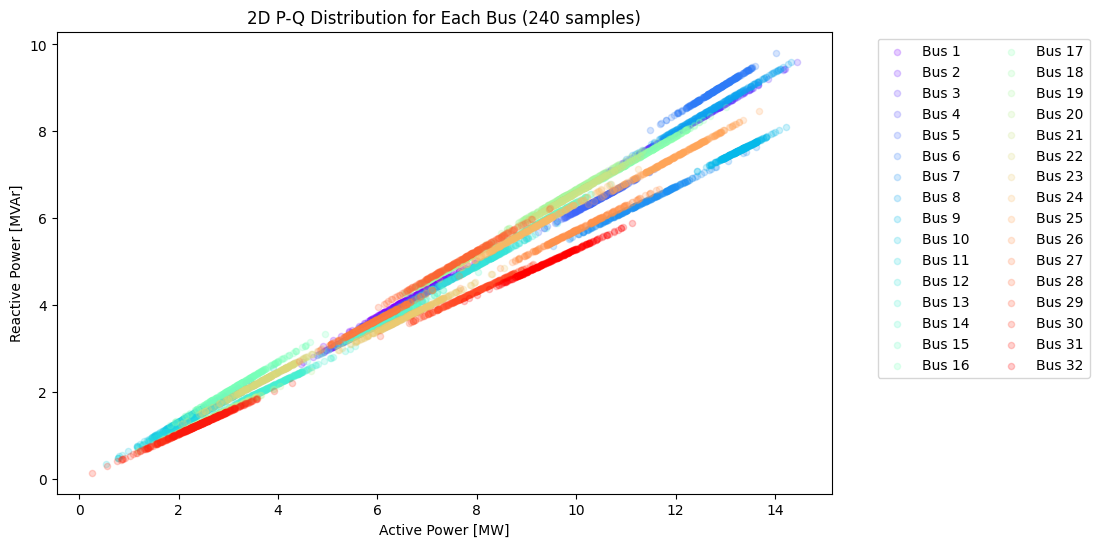

In [ ]:
import matplotlib.pyplot as plt

########################################
# Example: High-Dimensional Gaussian Loads
########################################
n_buses = len(net.bus)-1  # number of buses in the network except slack bus
mean_load = np.random.uniform(2, 15, size=n_buses)  # example bus load means in kW
cov_load = np.diag(np.random.uniform(0.1, 0.5, size=n_buses))  # diagonal covariance

# Generate N random samples from this distribution (240 for example)
N = 240
active_power = np.random.multivariate_normal(mean_load, cov_load, size=N)
active_power = np.abs(active_power)  # ensure positivity

# Simple approach for reactive power (Q ~ power_factor * P)
power_factor = np.random.uniform(0.5, 0.7, size=n_buses)
reactive_power = active_power * power_factor

########################################
# 2D P-Q DISTRIBUTION PLOT (240 SAMPLES PER BUS)
########################################
plt.figure(figsize=(10, 6))

# Use a colormap that can produce distinct colors for each bus
colors = plt.cm.rainbow(np.linspace(0, 1, n_buses))

for i in range(n_buses):
    plt.scatter(
        active_power[:, i],
        reactive_power[:, i],
        color=colors[i],
        alpha=0.2,
        s=20,
        label=f"Bus {i+1}"
    )

plt.title("2D P-Q Distribution for Each Bus (240 samples)")
plt.xlabel("Active Power [MW]")
plt.ylabel("Reactive Power [MVAr]")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2)
plt.show()


## Explanation of the Conditional GMM Fitting and Visualization Code

Below is a section-by-section explanation of the code snippet, which demonstrates how to:

1. **Fit a Gaussian Mixture Model (GMM)** on bus-level loads plus the overall mean load.
2. **Sample loads conditionally** upon a specified mean load value.
3. **Visualize** both the original distribution of mean loads and a comparison of bus-level data via boxplots.

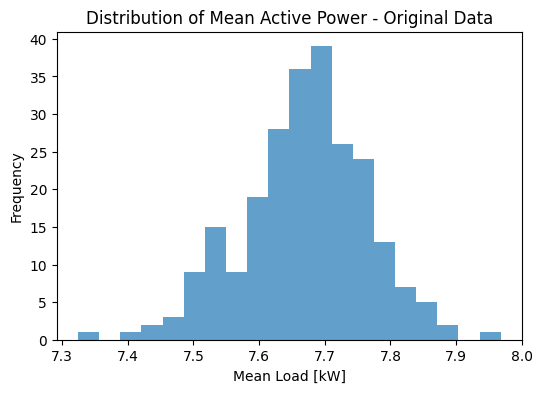

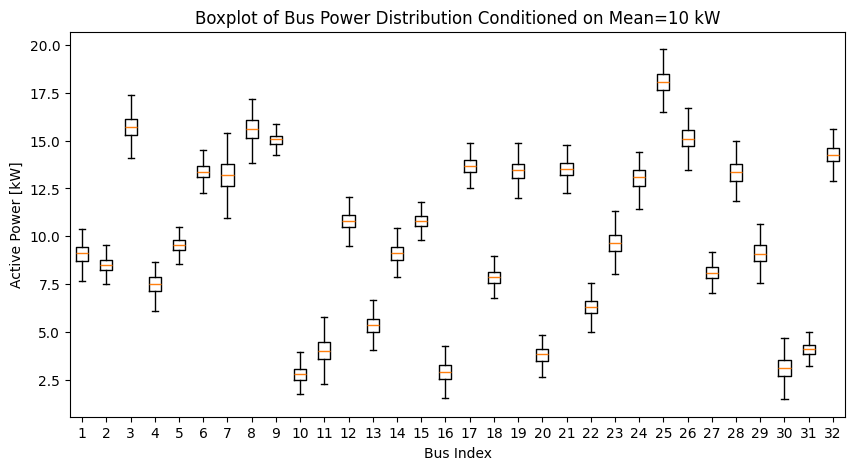

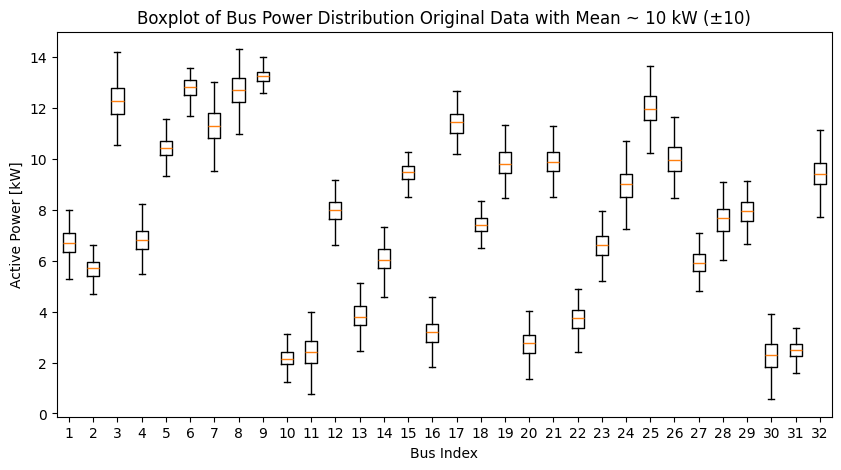

In [ ]:

##########################
# USING A GAUSSIAN MIXTURE TO FIT THE LOAD CONDITION
#     ON TOTAL DAILY CONSUMPTION
##########################
# Suppose we treat "total consumption per day" as the sum across all buses.
# We'll fit a GMM on the daily sums from these samples.

# Assume you have the following data:
#   active_power: shape (N, n_buses), i.e. 240 x 33
# Each row is one "sample" (time instance); each column is a bus.

########################################
#  Prepare Data: Active Power + Mean
########################################
N, n_buses = active_power.shape
mean_active_power = active_power.mean(axis=1)

# Stack it as the last column → shape: (N, n_buses + 1)
X = np.hstack([active_power, mean_active_power.reshape(-1, 1)])

########################################
# Fit a GMM on the (n_buses + 1)-dimensional data
########################################
n_components = 2  # number of mixture components (example)
gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=42)
gmm.fit(X)

########################################
# Define a function to sample from p(P | mean_load = M)
########################################
def sample_from_conditional_gmm(gmm, mean_value, n_samples=1):
    """
    Samples from the conditional distribution p(P_1, ..., P_n | mean_load = mean_value)
    given a fitted GMM in (n_buses + 1)-dimensional space.
    """
    d1 = gmm.means_.shape[1] - 1   # e.g. number of buses
    samples = np.zeros((n_samples, d1))

    # Arrays to store conditional parameters of each mixture component
    conditional_means = []
    conditional_covs = []
    mixture_weights = []

    for k in range(gmm.n_components):
        mu_k = gmm.means_[k]         # shape: (d1 + 1,)
        Sigma_k = gmm.covariances_[k]  # shape: (d1 + 1, d1 + 1)
        pi_k = gmm.weights_[k]

        # Partition mean vector
        mu_x1 = mu_k[:d1]           # shape: (d1,)
        mu_x2 = mu_k[d1:]           # shape: (1,)

        # Partition covariance
        Sigma_x1x1 = Sigma_k[:d1, :d1]    # (d1, d1)
        Sigma_x2x2 = Sigma_k[d1:, d1:]    # (1, 1)
        Sigma_x1x2 = Sigma_k[:d1, d1:]    # (d1, 1)
        Sigma_x2x1 = Sigma_k[d1:, :d1]    # (1, d1)

        sigma_x2x2 = Sigma_x2x2[0, 0]  # univariate

        # Conditional mean
        cond_mean = mu_x1 + (Sigma_x1x2[:, 0] / sigma_x2x2) * (mean_value - mu_x2[0])
        # Make sure cond_mean is 1D: shape (d1,)
        cond_mean = np.array(cond_mean, ndmin=1)

        # Conditional covariance
        #   Σ_x1|x2 = Σ_x1x1 - Σ_x1x2 Σ_x2x2^-1 Σ_x2x1
        # Note Sigma_x1x2 is (d1, 1), Sigma_x2x1 is (1, d1).
        cond_cov = Sigma_x1x1 - (Sigma_x1x2 @ Sigma_x2x1) / sigma_x2x2
        # Ensure shape is (d1, d1)
        cond_cov = np.atleast_2d(cond_cov)

        # Probability of X2 = mean_value in component k
        from math import sqrt, pi, exp
        def univariate_pdf(x, m, var):
            return 1 / np.sqrt(2 * pi * var) * np.exp(-0.5 * ((x - m) ** 2 / var))

        p_x2_given_k = univariate_pdf(mean_value, mu_x2[0], sigma_x2x2)
        mixture_weights.append(pi_k * p_x2_given_k)

        conditional_means.append(cond_mean)
        conditional_covs.append(cond_cov)

    # Normalize mixture weights
    mixture_weights = np.array(mixture_weights)
    mixture_weights /= mixture_weights.sum()

    # Sample from the conditional mixture distribution
    for i in range(n_samples):
        k_choice = np.random.choice(np.arange(gmm.n_components), p=mixture_weights)
        mean_k = conditional_means[k_choice]  # shape (d1,)
        cov_k = conditional_covs[k_choice]    # shape (d1, d1)

        # Draw a sample from the chosen (multivariate) normal
        samples[i, :] = np.random.multivariate_normal(mean_k, cov_k)

    return samples

########################################
# Plot the Distribution of mean_active_power (Original Data)
########################################
mean_active_power = active_power.mean(axis=1)
plt.figure(figsize=(6, 4))
plt.hist(mean_active_power, bins=20, alpha=0.7)
plt.title("Distribution of Mean Active Power - Original Data")
plt.xlabel("Mean Load [kW]")
plt.ylabel("Frequency")
plt.show()

########################################
# Conditional Samples from the GMM at mean_active_power
########################################
# Let's draw a larger set of conditional samples to visualize a distribution
num_conditional_samples_large = 500  # pick a larger number for better stats
sampled_target = 10
conditional_samples_large = sample_from_conditional_gmm(
    gmm,
    mean_value=sampled_target,
    n_samples=num_conditional_samples_large
)
conditional_samples_large = np.abs(conditional_samples_large)

# Boxplot of the bus-level power across the conditional samples
plt.figure(figsize=(10, 5))
plt.boxplot(conditional_samples_large, showfliers=False)
plt.title(f"Boxplot of Bus Power Distribution Conditioned on Mean={sampled_target} kW")
plt.xlabel("Bus Index")
plt.ylabel("Active Power [kW]")
plt.show()

########################################
# Plot Power Distribution of Original Data with Mean ~ 0.10
########################################
# Filter original dataset
tolerance = 10
mask = (mean_active_power >= sampled_target - tolerance) & (mean_active_power <= sampled_target + tolerance)
similar_data = active_power[mask]  # shape = (M, n_buses), M depends on how many rows match

# If we have at least one row matching:
if len(similar_data) > 0:
    plt.figure(figsize=(10, 5))
    plt.boxplot(similar_data, showfliers=False)
    plt.title(f"Boxplot of Bus Power Distribution Original Data with Mean ~ {sampled_target} kW (±{tolerance})")
    plt.xlabel("Bus Index")
    plt.ylabel("Active Power [kW]")
    plt.show()
else:
    print(f"No original samples found with mean load in [{sampled_target - tolerance}, {sampled_target + tolerance}].")


This script demonstrates how to:
1. Generate synthetic load scenarios for an IEEE 33-bus network using a trained Gaussian Mixture Model (GMM).
2. Sample multiple scenarios corresponding to different average load levels (lower and higher).
3. Run a DC power flow on each scenario with pandapower’s IEEE 33-bus case.
4. Extract the bus voltage magnitudes in kV and plot their distributions for each scenario.



 **Load Sampling from GMM**:
   - We call `sample_from_conditional_gmm(...)` twice, once for the lower mean load and once for the higher mean load.
   - This function returns synthetic load values (in MW) for each bus in each scenario.
   - We take the absolute value to ensure non-negative loads.

 **Run Power Flow**:
   - We create a helper function `run_dc_scenarios_and_get_angles_and_voltages(...)`.
   - For each scenario, we:
     a) Create a fresh pandapower 33-bus network (IEEE 33-bus).
     b) Remove any pre-existing loads.
     c) Add new loads for all buses from our synthetic load scenario.
     d) Run a power flow (using “dc” approximation in `runpp`).

 **Collect & Plot Results**:
   - We collect voltage magnitudes at each bus in kV from `net.res_bus`.
   - We create boxplots of these bus voltages to visualize how the voltage distribution changes across scenarios and load levels.



Mean of lower loads:  6.001936158003473
Mean of higher loads:  9.999807707667896
Mean voltage of smaller condition (pu):  0.9976206063678643
Mean voltage of larger condition (pu):  0.9961099890613239


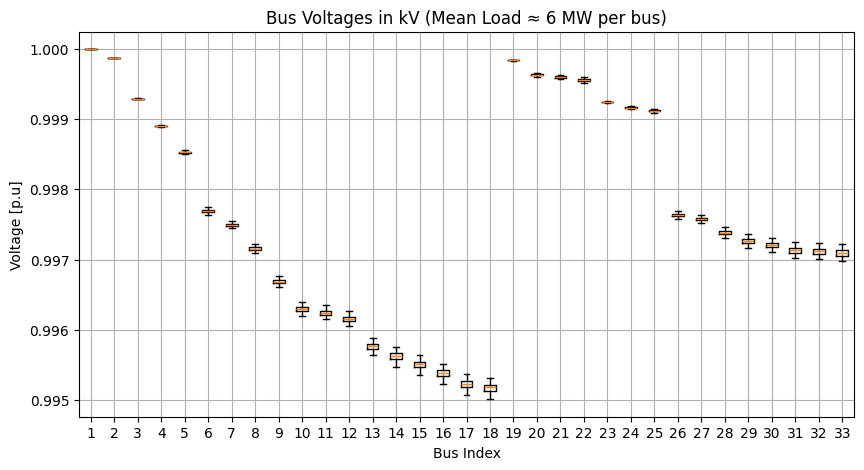

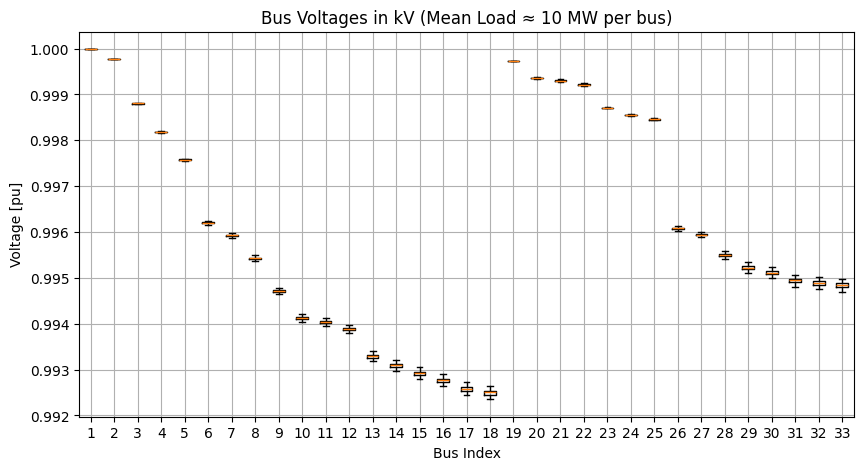

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --- ASSUMPTION: You already have a fitted GMM (gmm)

##########################
# CHOOSE SCENARIOS
##########################
# Here we still assume per-bus load values (from the GMM) in MW.
# Even though DC load flow ignores reactive power,
# the load levels must be within a realistic range.
lower_mean_value = 6  # MW per bus
higher_mean_value = 10 # MW per bus
num_samples = 200      # number of scenarios per mean load


##########################
# SAMPLE LOADS FOR LOWER & HIGHER MEAN
##########################
loads_lower = sample_from_conditional_gmm(gmm, mean_value=lower_mean_value, n_samples=num_samples)
loads_higher = sample_from_conditional_gmm(gmm, mean_value=higher_mean_value, n_samples=num_samples)


# Ensure non-negative loads (and use a minimum value to avoid zero load issues)
loads_lower = np.abs(loads_lower)
loads_higher = np.abs(loads_higher)
print('Mean of lower loads: ', loads_lower.mean())
print('Mean of higher loads: ', loads_higher.mean())


##########################
# FUNCTION: RUN DC POWER FLOW FOR MULTIPLE SCENARIOS
##########################
def run_dc_scenarios_and_get_angles_and_voltages(load_matrix):
    """
    Returns both bus angles (in degrees) and bus voltages (in kV) for each scenario.
    """
    num_scenarios, _ = load_matrix.shape
    voltage_results = np.zeros((num_scenarios, 33))
    power_factor = 0.3

    for i in range(num_scenarios):
        # for node_idx in input_data_pgm['sym_load']['node']:
        input_data_pgm['sym_load']['p_specified'][:32] =  load_matrix[i,:32] * 1000  # 1000 is for orrect the unit
        input_data_pgm['sym_load']['q_specified'] = input_data_pgm['sym_load']['p_specified'] * power_factor

        # Create a network of power grid model
        newpgm = PowerGridModel(input_data=input_data_pgm, system_frequency=50.0)

        # Run power flow
        newoutput = newpgm.calculate_power_flow(max_iterations = 100)

        voltage_results[i, :] = newoutput['node']['u_pu']
    return voltage_results

#########################
# RUN DC POWER FLOW FOR LOWER & HIGHER LOADS
##########################
voltages_lower = run_dc_scenarios_and_get_angles_and_voltages(loads_lower)
voltages_higher = run_dc_scenarios_and_get_angles_and_voltages(loads_higher)
print('Mean voltage of smaller condition (pu): ', voltages_lower.mean())
print('Mean voltage of larger condition (pu): ',voltages_higher.mean())

##########################
# PLOT VOLTAGE ANGLE DISTRIBUTIONS
##########################
plt.figure(figsize=(10, 5))
plt.boxplot(voltages_lower, showfliers=False)
plt.title(f"Bus Voltages in kV (Mean Load ≈ {lower_mean_value} MW per bus)")
plt.xlabel("Bus Index")
plt.ylabel("Voltage [p.u]")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.boxplot(voltages_higher, showfliers=False)
plt.title(f"Bus Voltages in kV (Mean Load ≈ {higher_mean_value} MW per bus)")
plt.xlabel("Bus Index")
plt.ylabel("Voltage [pu]")
plt.grid(True)
plt.show()
